In [141]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('lateky')

In [142]:
# def standardmap(x, y, K=1.2):
#     ynew = y - K*np.sin(2*np.pi*x)/(2*np.pi)
#     xnew = np.mod(x + ynew, 1)
#     return xnew, ynew

def standardmap(x, y, K=1.2):
    ynew = np.mod(y + K*np.sin(x), 2*np.pi)
    xnew = np.mod(x + ynew, 2*np.pi)
    return xnew, ynew

In [143]:
# xi = np.linspace(-0.5, 0.5, 10)
xi = np.linspace(0., 2*np.pi, 10)
Xi = np.meshgrid(xi, xi)
Xi = np.vstack((Xi[0].flatten(), Xi[1].flatten())).T

In [144]:
nev = 1000
Ev = np.empty(((nev,)+Xi.shape))
Ev[0] = Xi

In [145]:
Ev.shape

(1000, 100, 2)

In [146]:
K = 0.975
for i in range(1, Ev.shape[0]):
    evolved = np.array([standardmap(Ev[i-1,j,0], Ev[i-1,j,1], K) for j in range(Ev.shape[1])])
    Ev[i,:,:] = evolved

(-0.3141592653589793,
 6.5973445725385655,
 -0.3141592653589793,
 6.5973445725385655)

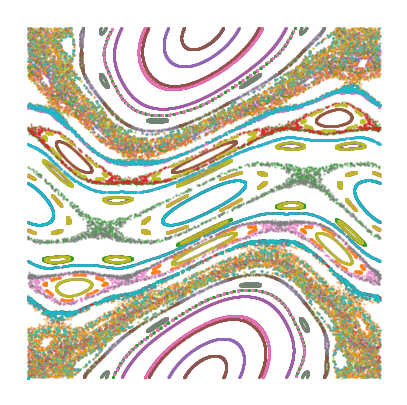

In [152]:
fig, ax = plt.subplots()
for i in range(len(Ev[0,:,0])):
    ax.scatter(Ev[:, i, 0], Ev[:, i, 1], s=0.5, alpha=0.5, zorder = 10)
ax.axis('off')

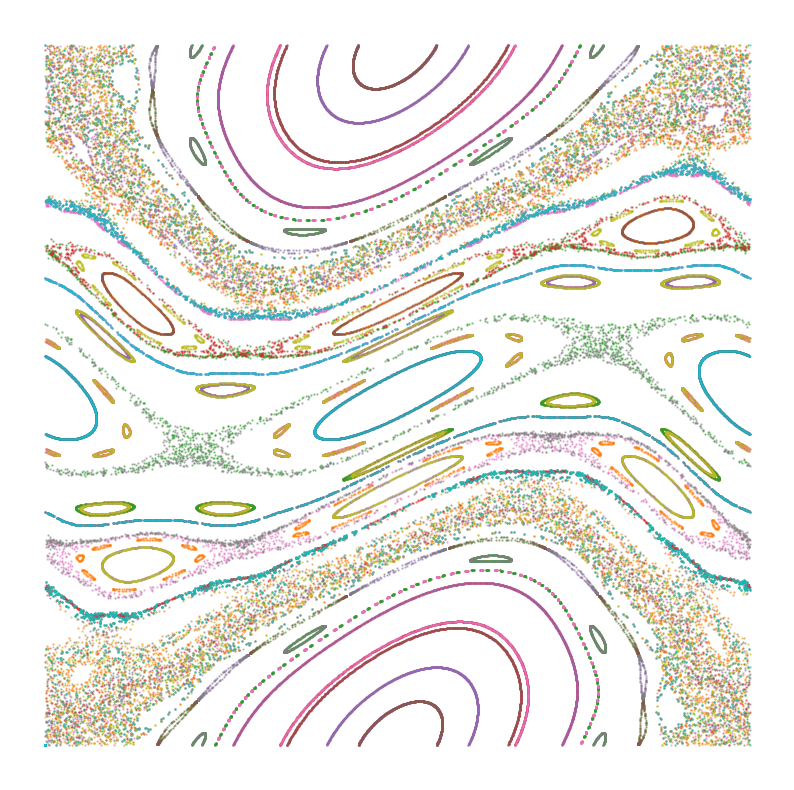

In [155]:
fig.set_size_inches(10, 10)
fig